# Spatial Analysis

### Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
from IPython.display import display, Markdown

### Define Paths

In [2]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

PROCESSED = ROOT / "data" / "processed"
OUTPUTS = ROOT / "outputs"

SPATIAL_DIR = OUTPUTS / "spatial"
FIGURES_SPATIAL = SPATIAL_DIR / "figures"
TABLES_SPATIAL = SPATIAL_DIR / "tables"

for p in [SPATIAL_DIR, FIGURES_SPATIAL, TABLES_SPATIAL]:
    p.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0])
print("FIGURES_SPATIAL:", FIGURES_SPATIAL)
print("TABLES_SPATIAL:", TABLES_SPATIAL)

Python: 3.11.9
FIGURES_SPATIAL: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\outputs\spatial\figures
TABLES_SPATIAL: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\outputs\spatial\tables


### Load Processed Queue Data

In [3]:
public = pd.read_csv(PROCESSED / "public_queue_clean_combined.csv")
c15 = pd.read_csv(PROCESSED / "cluster15_clean_combined.csv")
c14 = pd.read_csv(PROCESSED / "cluster14_clean.csv")

display(pd.DataFrame({
    "dataset": ["public", "cluster15", "cluster14"],
    "rows": [len(public), len(c15), len(c14)],
}))

,dataset,rows
0,public,2290
1,cluster15,170
2,cluster14,363


### Filter to California

In [4]:
def filter_ca(df):
    if "state" in df.columns:
        return df[df["state"].str.upper().eq("CA")].copy()
    return df.copy()

public_ca = filter_ca(public)
c15_ca = filter_ca(c15)
c14_ca = filter_ca(c14)

display(pd.DataFrame({
    "dataset": ["public_ca", "cluster15_ca", "cluster14_ca"],
    "rows": [len(public_ca), len(c15_ca), len(c14_ca)],
}))

,dataset,rows
0,public_ca,2076
1,cluster15_ca,147
2,cluster14_ca,363


### Load California County Geometries

In [5]:
ca_counties = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip"
)

ca_counties = ca_counties[ca_counties["STATEFP"] == "06"].copy()
ca_counties["county"] = ca_counties["NAME"].str.upper().str.strip()

ca_counties = ca_counties[["county", "geometry"]]

### Helpers

In [6]:
def norm_county_series(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(" County", "", regex=False)
         .str.strip()
         .str.upper()
         .replace({"NAN": np.nan})
    )

def county_mw(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """Sum MW by county -> county, mw_sum, label"""
    if "county" not in df.columns:
        return pd.DataFrame(columns=["county", "mw_sum", "label"])

    tmp = df.copy()
    tmp["county"] = norm_county_series(tmp["county"])
    tmp["mw_poi"] = pd.to_numeric(tmp.get("mw_poi", np.nan), errors="coerce")

    out = (
        tmp.groupby("county")["mw_poi"]
           .sum(min_count=1)
           .fillna(0)
           .rename("mw_sum")
           .reset_index()
    )
    out["label"] = label
    return out

def county_withdraw_share_resolved_mw(public_df: pd.DataFrame) -> pd.DataFrame:
    """
    Public only: withdrawn / (withdrawn + completed) in MW, by county.
    Returns county, withdraw_share, resolved_mw.
    """
    req = {"county", "sheet_outcome", "mw_poi"}
    missing = req - set(public_df.columns)
    if missing:
        raise ValueError(f"public_df missing required columns: {missing}")

    tmp = public_df.copy()
    tmp["county"] = norm_county_series(tmp["county"])
    tmp["mw_poi"] = pd.to_numeric(tmp["mw_poi"], errors="coerce")

    resolved = tmp[tmp["sheet_outcome"].isin(["withdrawn", "completed"])].copy()

    piv = (
        resolved.pivot_table(
            index="county",
            columns="sheet_outcome",
            values="mw_poi",
            aggfunc="sum",
            fill_value=0
        )
        .reset_index()
    )

    withdrawn = piv["withdrawn"] if "withdrawn" in piv.columns else 0
    completed = piv["completed"] if "completed" in piv.columns else 0
    piv["resolved_mw"] = withdrawn + completed

    piv["withdraw_share"] = np.where(
        piv["resolved_mw"] > 0,
        withdrawn / piv["resolved_mw"],
        np.nan
    )

    return piv[["county", "withdraw_share", "resolved_mw"]]

def clean_poi(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace(r"\s+", " ", regex=True)
         .str.strip()
         .replace({"NAN": np.nan})
    )

def top_poi_mw(df: pd.DataFrame, label: str, top_n: int = 20) -> pd.DataFrame:
    """Sum MW by POI -> poi, mw_sum, label"""
    if "poi" not in df.columns:
        return pd.DataFrame(columns=["poi", "mw_sum", "label"])

    tmp = df.copy()
    tmp["poi"] = clean_poi(tmp["poi"])
    tmp["mw_poi"] = pd.to_numeric(tmp.get("mw_poi", np.nan), errors="coerce")

    out = (
        tmp.groupby("poi")["mw_poi"]
           .sum(min_count=1)
           .fillna(0)
           .sort_values(ascending=False)
           .head(top_n)
           .rename("mw_sum")
           .reset_index()
    )
    out["label"] = label
    return out

In [7]:
ca_counties = ca_counties.copy()
ca_counties["county"] = norm_county_series(ca_counties["county"])

### 1) Geographic Distribution of Active Interconnection Capacity (Public Queue)

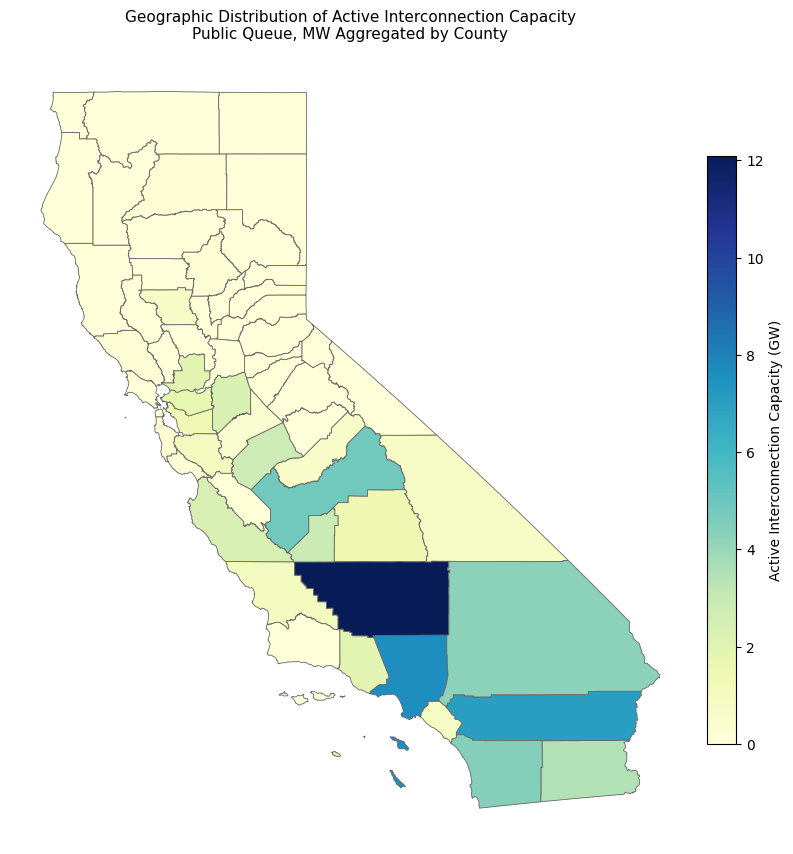

**Top Counties by Active Interconnection Capacity (Public Queue):**

,county,mw_sum,label,gw_sum
8,KERN,12099.98,public_active,12.09998
12,LOS ANGELES,7636.00,public_active,7.63600
18,RIVERSIDE,7012.00,public_active,7.01200
5,FRESNO,4883.28,public_active,4.88328
22,SAN DIEGO,4426.41,public_active,4.42641
21,SAN BERNARDINO,4255.00,public_active,4.25500
6,IMPERIAL,3450.44,public_active,3.45044
9,KINGS,2879.10,public_active,2.87910
14,MERCED,2835.00,public_active,2.83500
15,MONTEREY,2370.00,public_active,2.37000


In [8]:
pub_active = public_ca[public_ca["sheet_outcome"] == "active"].copy()
pub_cnty = county_mw(pub_active, "public_active")

gdf_pub = (
    ca_counties
    .merge(pub_cnty, on="county", how="left")
    .fillna({"mw_sum": 0})
)

gdf_pub["gw_sum"] = gdf_pub["mw_sum"] / 1_000.0

fig, ax = plt.subplots(1, 1, figsize=(8.5, 11))

gdf_pub.plot(
    column="gw_sum",
    cmap="YlGnBu",            
    linewidth=0.6,
    ax=ax,
    edgecolor="#666666",      
    legend=True,
    legend_kwds={
        "label": "Active Interconnection Capacity (GW)",
        "shrink": 0.55,         
        "pad": 0.02
    }
)

ax.set_title(
    "Geographic Distribution of Active Interconnection Capacity\n"
    "Public Queue, MW Aggregated by County",
    fontsize=11,
    pad=12
)

ax.axis("off")

plt.tight_layout()
plt.savefig(
    FIGURES_SPATIAL / "06a_public_active_capacity_by_county.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(Markdown("**Top Counties by Active Interconnection Capacity (Public Queue):**"))
display(
    pub_cnty
    .assign(gw_sum=lambda d: d["mw_sum"] / 1_000.0)
    .sort_values("mw_sum", ascending=False)
    .head(15)
)

### 2) Spatial Variation in Withdrawal Shares (Public Queue, Resolved MW)

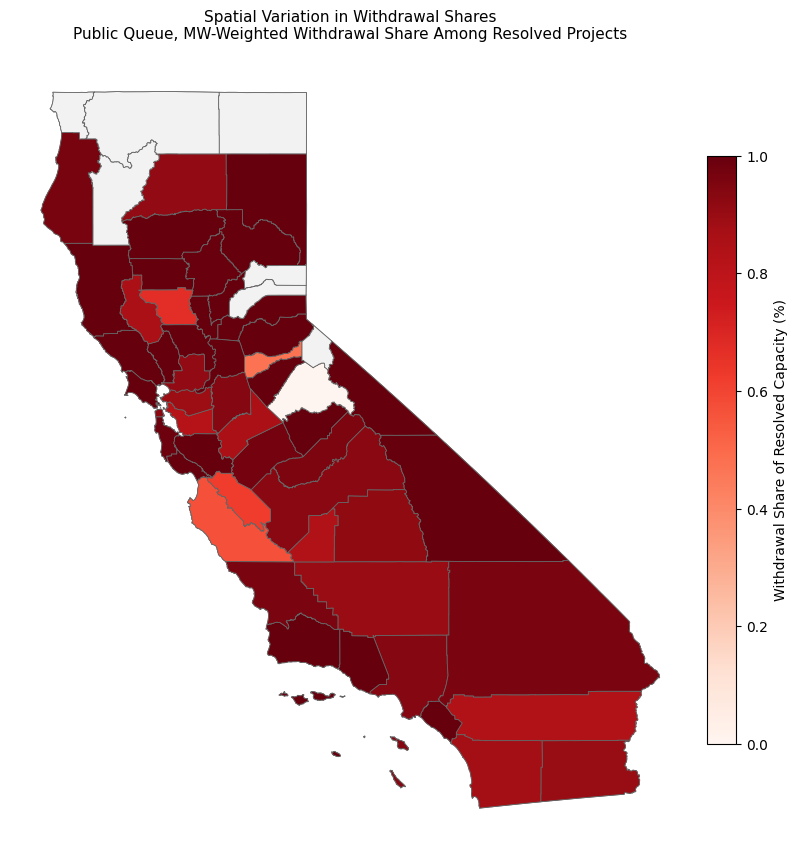

**Highest Withdrawal-Share Counties (Resolved MW Only):**

sheet_outcome,county,withdraw_share,resolved_mw
1,ALAMEDA COUNTY,100.0,150.000
4,CALAVERAS,100.0,100.000
11,GLENN,100.0,237.000
8,EL DORADO,100.0,160.500
5,CHURCHILL/PERSHING,100.0,364.200
10,FRESNO COUNTY,100.0,250.000
23,LAKE/SONOMA,100.0,201.000
24,LASSEN,100.0,318.018
20,KINGS/KERN,100.0,20.000
17,KERN/INYO,100.0,120.000


In [11]:
pub_with = county_withdraw_share_resolved_mw(public_ca)

gdf_with = ca_counties.merge(pub_with, on="county", how="left")

fig, ax = plt.subplots(1, 1, figsize=(8.5, 11))

ca_counties.plot(
    ax=ax,
    color="#f2f2f2",
    edgecolor="#666666",
    linewidth=0.6
)

gdf_with.plot(
    column="withdraw_share",
    cmap="Reds",
    linewidth=0.6,
    ax=ax,
    edgecolor="#666666",
    legend=True,
    vmin=0, vmax=1,
    missing_kwds={
        "color": "#f2f2f2",
        "label": "No Resolved MW"
    },
    legend_kwds={
        "label": "Withdrawal Share of Resolved Capacity (%)",
        "shrink": 0.55,
        "pad": 0.02
    }
)

ax.set_title(
    "Spatial Variation in Withdrawal Shares\n"
    "Public Queue, MW-Weighted Withdrawal Share Among Resolved Projects",
    fontsize=11,
    pad=12
)
ax.axis("off")

plt.tight_layout()
plt.savefig(
    FIGURES_SPATIAL / "06b_public_withdraw_share_by_county.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(Markdown("**Highest Withdrawal-Share Counties (Resolved MW Only):**"))
display(
    pub_with
    .sort_values("withdraw_share", ascending=False)
    .head(15)
    .assign(withdraw_share=lambda d: (d["withdraw_share"] * 100).round(1))
)

## 3) Capacity Concentration at Points of Interconnection

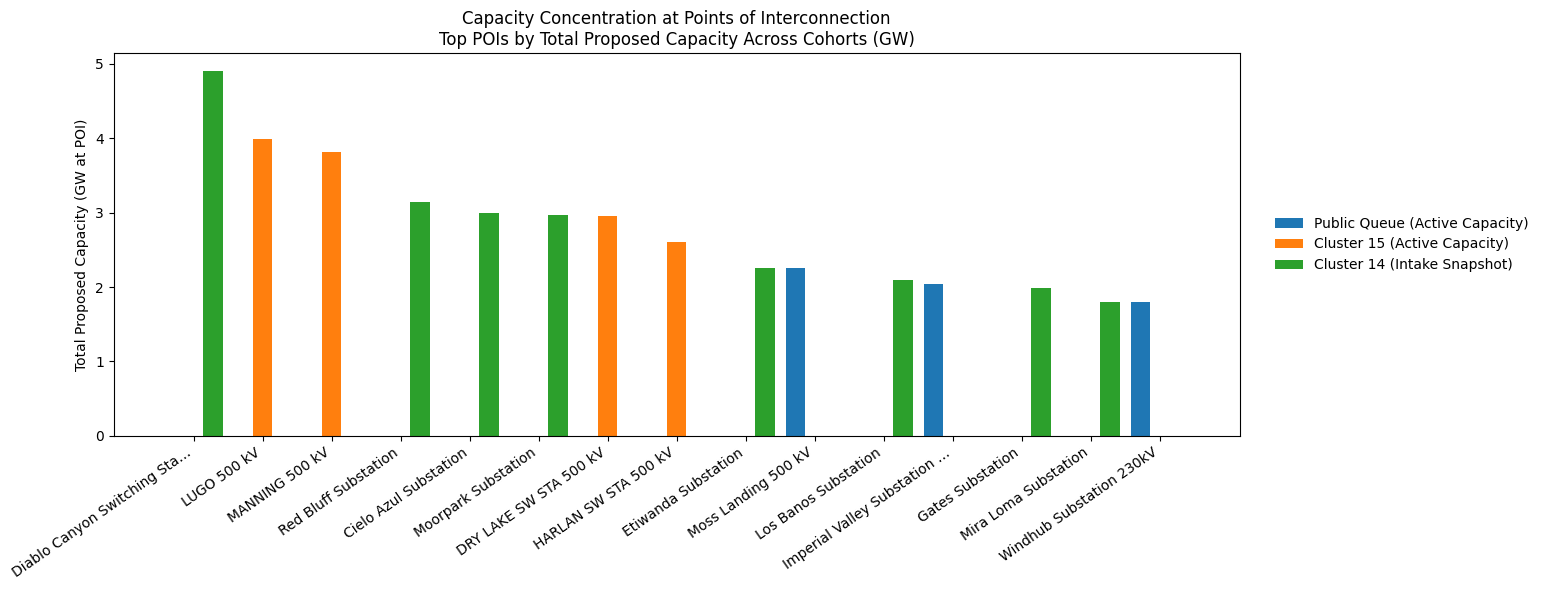

**Top POIs table (by cohort):**

,poi,mw_sum,label,gw_sum
60,Diablo Canyon Switching Station,4900.000,Cluster 14 (Intake),4.900000
61,Red Bluff Substation,3150.000,Cluster 14 (Intake),3.150000
62,Cielo Azul Substation,3000.000,Cluster 14 (Intake),3.000000
63,Moorpark Substation,2975.000,Cluster 14 (Intake),2.975000
64,Etiwanda Substation,2250.000,Cluster 14 (Intake),2.250000
65,Los Banos Substation,2100.000,Cluster 14 (Intake),2.100000
66,Gates Substation,1989.910,Cluster 14 (Intake),1.989910
67,Mira Loma Substation,1800.000,Cluster 14 (Intake),1.800000
68,Whirlwind Substation,1750.000,Cluster 14 (Intake),1.750000
69,Midway Substation,1667.090,Cluster 14 (Intake),1.667090


In [13]:
def clean_poi_label(s: str, max_len: int = 28) -> str:
    s = str(s).strip()
    s = " ".join(s.split()) 
    if len(s) > max_len:
        return s[: max_len - 1] + "…"
    return s

t_pub = top_poi_mw(public_ca[public_ca["sheet_outcome"] == "active"], "Public Queue (Active)", top_n=30)
t_15  = top_poi_mw(c15_ca[c15_ca["sheet_outcome"] == "active"], "Cluster 15 (Active)", top_n=30)
t_14  = top_poi_mw(c14_ca, "Cluster 14 (Intake)", top_n=30)

union = pd.concat([t_pub, t_15, t_14], ignore_index=True)

# Choose top POIs overall (stable x-axis)
pois = (
    union.groupby("poi")["mw_sum"]
         .sum()
         .sort_values(ascending=False)
         .head(15)
         .index
         .tolist()
)

def series(label):
    s = union.loc[union["label"].eq(label)].set_index("poi")["mw_sum"]
    return s.reindex(pois).fillna(0).values

to_gw = 1_000.0
pub_gw = series("Public Queue (Active)") / to_gw
c15_gw = series("Cluster 15 (Active)") / to_gw
c14_gw = series("Cluster 14 (Intake)") / to_gw

poi_labels = [clean_poi_label(p) for p in pois]

x = np.arange(len(pois))
w = 0.28

plt.figure(figsize=(15.5, 6.0))
plt.bar(x - w, pub_gw, width=w, label="Public Queue (Active Capacity)")
plt.bar(x,     c15_gw, width=w, label="Cluster 15 (Active Capacity)")
plt.bar(x + w, c14_gw, width=w, label="Cluster 14 (Intake Snapshot)")

plt.xticks(x, poi_labels, rotation=35, ha="right")
plt.ylabel("Total Proposed Capacity (GW at POI)")

plt.title(
    "Capacity Concentration at Points of Interconnection\n"
    "Top POIs by Total Proposed Capacity Across Cohorts (GW)"
)

plt.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()

plt.savefig(
    FIGURES_SPATIAL / "06c_poi_capacity_concentration_top_pois.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(Markdown("**Top POIs table (by cohort):**"))
display(
    union.assign(gw_sum=lambda d: d["mw_sum"] / 1_000.0)
         .sort_values(["label", "mw_sum"], ascending=[True, False])
         .head(40)
)